In [9]:
from common import *
from experiment import *
from data import RawData, PlottableData

# Initialize data

* We aim to test releases of BBRv1 dating back to 2016.
* In **TCPBenchmark**, the Python code keeps the `<cca>` as is and sets the Linux 
  congestion control module `sysctl -w net.ipv4.tcp_congestion_control=<cca>`.
* This notebook is only for plotting data. Execute the data on each Linux kernel
  and aggregate the data separately.

<!-- Not in use:
* In **QUICBenchmark**, the Python code converts the `<cca>` into an `<option>`
such as `TBBR-20240101`. The Chromium QUIC code receives this option via
`--client_connection_options=<option>` and `--connection_options=<option>`.
_We should pre-compile congestion control files linked to these options
in the Chromium QUIC code._
* These may be challenging, depending on how consistent the interfaces
between Linux kernel congestion control modules and TCP, and
Chromium QUIC congestion control modules and the newest toy client
and server, are over time.
* In the TCP benchmark, we can add another layer in the Python code from the
date to the actual module, similar to what exists in the QUIC benchmark. -->

In [16]:
# Generate the labels to test. Each treatment needs to run on a Linux kernel with the correctly compiled bbr commit.
cca_labels = [
    ('bbr', 'bbr-yyyymmdd-hash'), # Or some other reference to the version
    ('bbr', 'bbr-yyyymmdd-hash'),
    ('bbr', 'bbr-yyyymmdd-hash'),
    ('bbr', 'bbr-yyyymmdd-hash'),
    ('bbr', 'bbr-yyyymmdd-hash'),
    ('bbr2', 'bbr2-yyyymmdd-hash'), # google/bbr/v2alpha
    ('bbr', 'bbr3-yyyymmdd-hash'), # google/bbr/v3
]

In [17]:
# Generate the treatments
treatments = {
    'tcp': [],
    'pep': [],
}
for cca, label in cca_labels:
    treatments['tcp'].append(TCPTreatment(cca=cca, pep=False, label=f'tcp_{label}'))
    treatments['pep'].append(TCPTreatment(cca=cca, pep=True, label=f'pep_{label}'))
print(list(treatments.keys()))

['tcp', 'pep']


In [22]:
# Generate a representative network setting and data size
num_trials = 10
network_setting = NetworkSetting(delay1=1, delay2=25, loss1='1', loss2='0', bw1=300, bw2=100)
data_size = int(10*1000000*100/8)  # 10x the bottleneck bandwidth

# Execute experiment on a single machine

For a given index, execute the TCP and PEP experiment on this machine.
The script automatically writes the data to the correct subdirectory in `data/`.
To aggregate all the data, we can `rsync` each the `data/` directory from each server
with the `data/` directory on a central machine. Then execute the remainder of the
Jupyter notebook to plot the data together.

In [24]:
# Define the experiment
index = 0
exp = Experiment(
    num_trials=num_trials,
    treatments=[treatments['tcp'][0], treatments['pep'][0]],
    network_settings=[network_setting],
    data_sizes=[data_size],
)

# Parse data
execute = False # set to True
raw_data = RawData(exp, execute=execute)

MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label tcp_bbr-yyyymmdd-hash tcp -cca bbr -n 125000000
MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label pep_bbr-yyyymmdd-hash tcp --pep -cca bbr -n 125000000


# Plotting functions

In [19]:
def plot_bbr_over_time(data, ccas, treatments, delta=40, title='BBR Over Time', ylabel='Goodput (Mbit/s)'):
    plt.figure(figsize=(6, 4))

    assert len(data.network_settings) == 1
    network = data.network_settings[0]
    assert len(data.data_sizes) == 1
    data_size = data.data_sizes[0]

    for label, cca_treatments in treatments.items():
        xs = []
        ys = []
        yerr_lower = []
        yerr_upper = []

        for cca_treatment in cca_treatments:
            sublabel = cca_treatment.label()
            subdata = data.data[sublabel][network].get(data_size)
            if subdata is None:
                continue
            xs.append(sublabel)
            ys.append(subdata.p(50))
            yerr_lower.append(y.p(50) - y.p(50-delta))
            yerr_upper.append(y.p(50+delta) - y.p(50))

        plt.errorbar(xs, ys, yerr=(yerr_lower, yerr_upper), marker='.', capsize=5, label=label)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.grid()
    plt.ylim(0)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    plt.show()

# Plot data

MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label tcp_bbr-yyyymmdd-hash tcp -cca bbr -n 125000000
MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label tcp_bbr-yyyymmdd-hash tcp -cca bbr -n 125000000
MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label tcp_bbr-yyyymmdd-hash tcp -cca bbr -n 125000000
MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label tcp_bbr-yyyymmdd-hash tcp -cca bbr -n 125000000
MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label tcp_bbr-yyyymmdd-hash tcp -cca bbr -n 125000000
MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label tcp_bbr2-yyyymmdd-hash tcp -cca bbr2 -n 125000000
MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label tcp_bbr3-yyyymmdd-hash tcp -cca bbr -n 125000000
MISSING: sudo -E python3 emulation/main.py --bw1 300 --bw2 100 -t 10 --label pep_bbr-yyyymmdd-hash tcp --pep -cca bbr -n 1

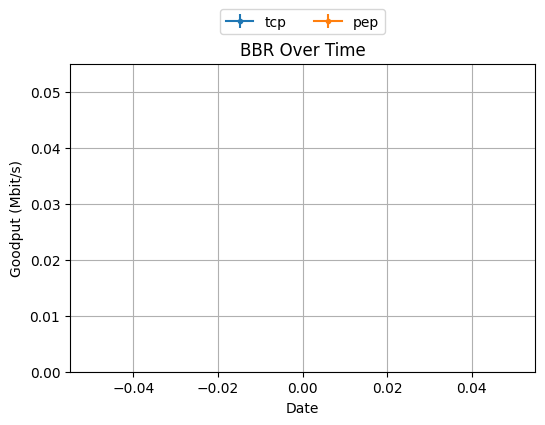

In [21]:
# Define the experiment
exp = Experiment(
    num_trials=num_trials,
    treatments=sum(treatments.values(), []),
    network_settings=[network_setting],
    data_sizes=[data_size],
)

# Parse data
raw_data = RawData(exp, execute=False)

# Convert to plottable data
metric = 'throughput_mbps'
plottable_data = PlottableData(raw_data, metric=metric)
plot_bbr_over_time(plottable_data, ccas=ccas, treatments=treatments)